Jeyner Arango 201106
 
Oscar Méndez 20402

# Proyecto Final

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import randint, uniform
import swifter

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, concatenate, Dense
from tensorflow.keras.models import Model
from keras import backend as K
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Preparacion del Modelo

In [2]:
def regression_report(y_true, y_pred, name):
    print(name)
    print('std =', np.std(y_true))
    print('rmse =', np.sqrt(mean_squared_error(y_true, y_pred)))
    print('r2 =', r2_score(y_true, y_pred), '\n')

In [35]:
df = pd.read_csv('train_features.csv')
df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,spelling_errors_essay,grammar_errors_essay,...,gunningfog_score_ratio,smog_score_ratio,clauses_prop_ratio,sub_clauses_prop_ratio,verb_phrases_prop_ratio,noun_phrases_prop_ratio,chars_per_word_ratio,words_per_sentence_ratio,sybl_per_sentence_ratio,words_similarity
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,5,3,...,0.801371,0.909527,1.576331,2.927473,NaN,0.758974,0.965068,0.673895,0.668706,0.106910
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",2,3,...,0.616276,0.349426,1.610182,1.548252,NaN,0.999226,0.880900,0.657230,0.583910,0.096492
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,32,2,...,1.255015,1.022929,0.634366,0.930403,NaN,0.759513,0.943478,1.593058,1.531459,0.085946
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,5,3,...,1.111391,1.022929,0.995298,0.000000,NaN,1.564039,1.072084,0.493716,0.544846,0.098658
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,29,15,...,0.740977,0.846515,1.539122,0.816677,NaN,0.926323,0.990123,0.672317,0.667582,0.103167


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 90 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   student_id                    7165 non-null   object 
 1   prompt_id                     7165 non-null   object 
 2   text                          7165 non-null   object 
 3   content                       7165 non-null   float64
 4   wording                       7165 non-null   float64
 5   prompt_question               7165 non-null   object 
 6   prompt_title                  7165 non-null   object 
 7   prompt_text                   7165 non-null   object 
 8   spelling_errors_essay         7165 non-null   int64  
 9   grammar_errors_essay          7165 non-null   int64  
 10  punctuation_marks_essay       7165 non-null   int64  
 11  essay_lemmatized              7165 non-null   object 
 12  text_length_essay             7165 non-null   int64  
 13  sen

Separamos el dataset del train y del validation

In [5]:
X = df.drop([
    'student_id', 'prompt_id', 'prompt_title', 'content', 'wording'
], axis=1)

Y = df[['content', 'wording']]

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=24)

In [7]:
text_cols = [
    'text', 'essay_lemmatized', 'essay_no_stopwords',
    'prompt_text', 'prompt_lemmatized', 'prompt_no_stopwords',
    'prompt_question', 'question_lemmatized', 'question_no_stopwords'
]

X_train_features = X_train.drop(text_cols, axis=1)

X_val_features = X_val.drop(text_cols, axis=1)

Entrenamos nuestro primer modelo con todas las features.

In [8]:
xgb_model_1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=24,
    learning_rate=0.05,
    min_child_weight=100,
    max_depth=20,
    n_estimators=100
)

multi_xgb_model_1 = MultiOutputRegressor(xgb_model_1).fit(X_train_features, Y_train)

multi_xgb_model_1.fit(X_train_features, Y_train)
predictions_xgb = multi_xgb_model_1.predict(X_val_features)

In [9]:
regression_report(Y_train['content'], multi_xgb_model_1.predict(X_train_features)[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], predictions_xgb[:, 0], 'CONTENT TEST')

regression_report(Y_train['wording'], multi_xgb_model_1.predict(X_train_features)[:, 1], 'WORDING TRAIN')
regression_report(Y_val['wording'], predictions_xgb[:, 1], 'WORDING TEST')

CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.39389386301925006
r2 = 0.8589487416635762 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.4607549811780617
r2 = 0.796756937542155 

WORDING TRAIN
std = 1.04289755999341
rmse = 0.5229289971289345
r2 = 0.7485786542153607 

WORDING TEST
std = 1.0075341042027464
rmse = 0.6174299774518763
r2 = 0.6244602508090671 



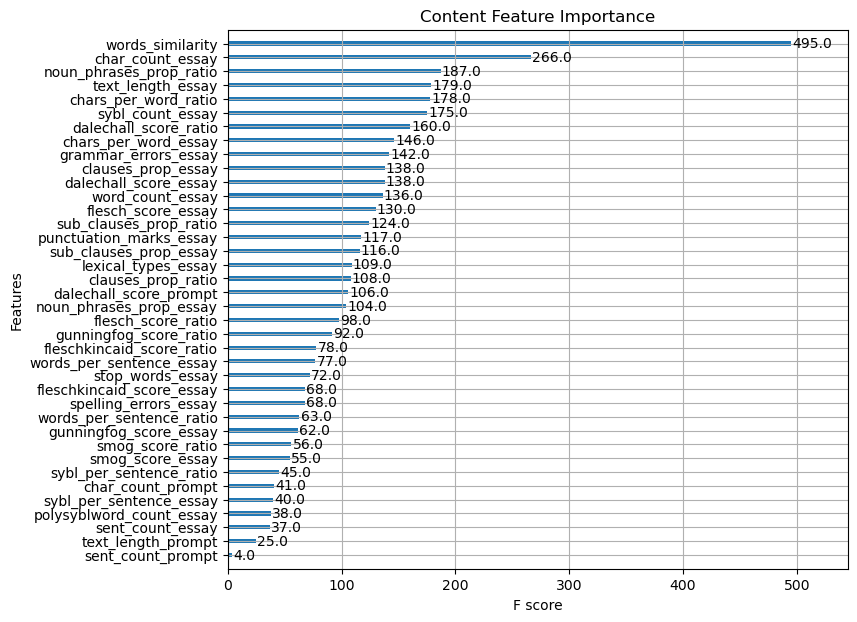

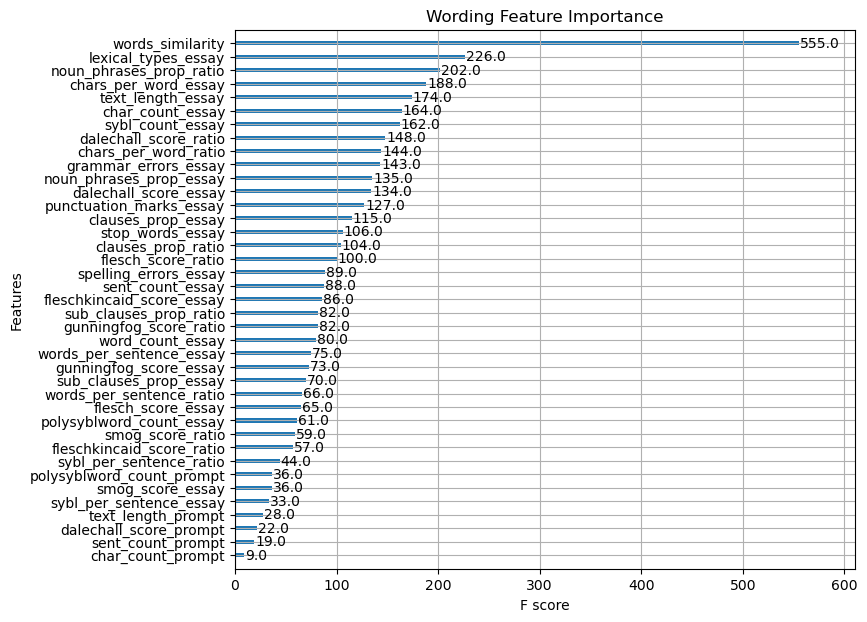

In [10]:
fig, ax = plt.subplots(figsize=(8, 7))
xgb.plot_importance(multi_xgb_model_1.estimators_[0], height=0.3, title='Content Feature Importance', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(8, 7))
xgb.plot_importance(multi_xgb_model_1.estimators_[1], height=0.3, title='Wording Feature Importance', ax=ax)
plt.show()

Seleccionamos solamente las features que aportan suficiente información al modelo

In [11]:
content_importances = multi_xgb_model_1.estimators_[0].get_booster().get_score(importance_type='weight')
wording_importances = multi_xgb_model_1.estimators_[1].get_booster().get_score(importance_type='weight')

features_used = set(content_importances.keys()).union(set(wording_importances.keys()))
features_to_keep = list(features_used - {'sent_count_pompt', 'char_count_prompt', 'text_length_prompt', 'polysyblword_count_prompt'})

print("Total selected features:", len(features_to_keep))

xgb_model_2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=24,
    learning_rate=0.05,
    min_child_weight=100,
    max_depth=20,
    n_estimators=100
)

multi_xgb_model_2 = MultiOutputRegressor(xgb_model_2)

multi_xgb_model_2.fit(X_train_features[features_to_keep], Y_train)
predictions_xgb = multi_xgb_model_2.predict(X_val_features[features_to_keep])

Total selected features: 36


In [12]:
regression_report(Y_train['content'], multi_xgb_model_2.predict(X_train_features[features_to_keep])[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], predictions_xgb[:, 0], 'CONTENT TEST')

regression_report(Y_train['wording'], multi_xgb_model_2.predict(X_train_features[features_to_keep])[:, 1], 'WORDING TRAIN')
regression_report(Y_val['wording'], predictions_xgb[:, 1], 'WORDING TEST')

CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.39376813338141836
r2 = 0.859038773496625 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.4611843695947968
r2 = 0.7963779470376445 

WORDING TRAIN
std = 1.04289755999341
rmse = 0.5234339458917947
r2 = 0.748092866687543 

WORDING TEST
std = 1.0075341042027464
rmse = 0.6178452748454916
r2 = 0.6239548878170559 



In [13]:
features_to_keep

['sybl_per_sentence_ratio',
 'flesch_score_essay',
 'dalechall_score_ratio',
 'fleschkincaid_score_essay',
 'chars_per_word_ratio',
 'words_per_sentence_ratio',
 'dalechall_score_essay',
 'chars_per_word_essay',
 'stop_words_essay',
 'sybl_count_essay',
 'sent_count_essay',
 'flesch_score_ratio',
 'lexical_types_essay',
 'char_count_essay',
 'spelling_errors_essay',
 'clauses_prop_essay',
 'dalechall_score_prompt',
 'sub_clauses_prop_ratio',
 'noun_phrases_prop_ratio',
 'fleschkincaid_score_ratio',
 'punctuation_marks_essay',
 'gunningfog_score_essay',
 'smog_score_essay',
 'polysyblword_count_essay',
 'text_length_essay',
 'words_per_sentence_essay',
 'sybl_per_sentence_essay',
 'grammar_errors_essay',
 'gunningfog_score_ratio',
 'clauses_prop_ratio',
 'noun_phrases_prop_essay',
 'word_count_essay',
 'smog_score_ratio',
 'words_similarity',
 'sub_clauses_prop_essay',
 'sent_count_prompt']

## Modelos Deep Learning

In [14]:
model_1 = Sequential()
model_1.add(Dense(1, input_dim=36, activation='linear'))
model_1.compile(optimizer='adam', loss='mse')

history_1 = model_1.fit(
    X_train_features[features_to_keep], Y_train['content'],
    batch_size=128,
    epochs=100,
    validation_data=(X_val_features[features_to_keep], Y_val['content'])
)

Epoch 1/100
45/45 [==============================] - 1s 6ms/step - loss: 10719.4365 - val_loss: 5024.4570
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 2637.6040 - val_loss: 950.1757
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 452.2138 - val_loss: 173.4102
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 123.3432 - val_loss: 92.8812
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 93.5234 - val_loss: 84.2109
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 87.7289 - val_loss: 79.2804
Epoch 7/100
45/45 [==============================] - 0s 2ms/step - loss: 82.5933 - val_loss: 74.6166
Epoch 8/100
45/45 [==============================] - 0s 2ms/step - loss: 77.6310 - val_loss: 70.1530
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 72.9579 - val_loss: 65.9681
Epoch 10/100
45/45 [==============================] - 0s 2ms/step - loss: 68.467

In [15]:
model_2 = Sequential()
model_2.add(Dense(15, input_dim=36, activation='relu'))
model_2.add(Dense(1, activation='linear'))
model_2.compile(optimizer='adam', loss='mse')

history_2 = model_2.fit(
    X_train_features[features_to_keep], Y_train['content'],
    batch_size=128,
    epochs=100,
    validation_data=(X_val_features[features_to_keep], Y_val['content'])
)

Epoch 1/100
45/45 [==============================] - 1s 6ms/step - loss: 3013.6262 - val_loss: 300.4011
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 173.5350 - val_loss: 134.5203
Epoch 3/100
45/45 [==============================] - 0s 2ms/step - loss: 124.7596 - val_loss: 106.6677
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 100.2225 - val_loss: 84.1351
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 78.9621 - val_loss: 65.7798
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 61.3681 - val_loss: 50.2542
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 47.2781 - val_loss: 38.5012
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 36.3153 - val_loss: 29.2287
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 28.0611 - val_loss: 22.5893
Epoch 10/100
45/45 [==============================] - 0s 3ms/step - loss: 21.9229 -

In [16]:
model_3 = Sequential()
model_3.add(Dense(25, input_dim=36, activation='relu'))
model_3.add(Dense(10, activation='relu'))
model_3.add(Dense(1, activation='linear'))
model_3.compile(optimizer='adam', loss='mse')

history_3 = model_3.fit(
    X_train_features[features_to_keep], Y_train['content'],
    batch_size=128,
    epochs=100,
    validation_data=(X_val_features[features_to_keep], Y_val['content'])
)

Epoch 1/100
45/45 [==============================] - 1s 6ms/step - loss: 3003.5811 - val_loss: 198.6625
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 83.7590 - val_loss: 43.8666
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 36.2405 - val_loss: 29.3787
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 25.1434 - val_loss: 21.8028
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 18.9799 - val_loss: 17.0681
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 14.7403 - val_loss: 12.5842
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 11.1627 - val_loss: 9.4390
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 8.9189 - val_loss: 7.0747
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 7.0267 - val_loss: 5.9388
Epoch 10/100
45/45 [==============================] - 0s 3ms/step - loss: 6.0041 - val_loss: 

Epoch 83/100
45/45 [==============================] - 0s 3ms/step - loss: 0.4215 - val_loss: 0.3997
Epoch 84/100
45/45 [==============================] - 0s 3ms/step - loss: 0.4265 - val_loss: 0.4539
Epoch 85/100
45/45 [==============================] - 0s 3ms/step - loss: 0.5552 - val_loss: 0.4865
Epoch 86/100
45/45 [==============================] - 0s 3ms/step - loss: 0.4208 - val_loss: 0.6923
Epoch 87/100
45/45 [==============================] - 0s 3ms/step - loss: 0.4164 - val_loss: 0.3673
Epoch 88/100
45/45 [==============================] - 0s 3ms/step - loss: 0.4302 - val_loss: 0.4119
Epoch 89/100
45/45 [==============================] - 0s 3ms/step - loss: 0.4073 - val_loss: 0.4169
Epoch 90/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3863 - val_loss: 0.3704
Epoch 91/100
45/45 [==============================] - 0s 3ms/step - loss: 0.4074 - val_loss: 0.3524
Epoch 92/100
45/45 [==============================] - 0s 2ms/step - loss: 0.3918 - val_loss: 0.5242


In [17]:
model_4 = Sequential()
model_4.add(Dense(20, input_dim=36, activation='relu'))
model_4.add(Dense(15, activation='relu'))
model_4.add(Dense(10, activation='relu'))
model_4.add(Dense(1, activation='linear'))
model_4.compile(optimizer='adam', loss='mse')

history_4 = model_4.fit(
    X_train_features[features_to_keep], Y_train['content'],
    batch_size=128,
    epochs=100,
    validation_data=(X_val_features[features_to_keep], Y_val['content'])
)

Epoch 1/100
45/45 [==============================] - 1s 6ms/step - loss: 93.9362 - val_loss: 14.3541
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 8.8343 - val_loss: 5.3397
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 5.0386 - val_loss: 3.2736
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 3.1635 - val_loss: 2.0302
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 2.1507 - val_loss: 1.7088
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 1.9200 - val_loss: 1.5784
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 1.7181 - val_loss: 1.3905
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 1.5676 - val_loss: 1.3532
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 1.4519 - val_loss: 1.4200
Epoch 10/100
45/45 [==============================] - 0s 3ms/step - loss: 1.3876 - val_loss: 1.0737
Epoch 1

Epoch 83/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3417 - val_loss: 0.2816
Epoch 84/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3059 - val_loss: 0.2820
Epoch 85/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3089 - val_loss: 0.3411
Epoch 86/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3631 - val_loss: 0.2920
Epoch 87/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3424 - val_loss: 0.3596
Epoch 88/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3210 - val_loss: 0.2774
Epoch 89/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3129 - val_loss: 0.2747
Epoch 90/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2959 - val_loss: 0.2799
Epoch 91/100
45/45 [==============================] - 0s 4ms/step - loss: 0.3677 - val_loss: 0.2787
Epoch 92/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3238 - val_loss: 0.2739


In [18]:
model_3_sigmoid = Sequential()
model_3_sigmoid.add(Dense(25, input_dim=36, activation='sigmoid'))
model_3_sigmoid.add(Dense(10, activation='sigmoid'))
model_3_sigmoid.add(Dense(1, activation='linear'))
model_3_sigmoid.compile(optimizer='adam', loss='mse')

history_3_sigmoid = model_3_sigmoid.fit(
    X_train_features[features_to_keep], Y_train['content'],
    batch_size=128,
    epochs=100,
    validation_data=(X_val_features[features_to_keep], Y_val['content'])
)

Epoch 1/100
45/45 [==============================] - 1s 11ms/step - loss: 1.9040 - val_loss: 1.3367
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 1.2048 - val_loss: 1.0252
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 1.0305 - val_loss: 0.9407
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 0.9690 - val_loss: 0.8930
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 0.9233 - val_loss: 0.8501
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 0.8795 - val_loss: 0.8088
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 0.8346 - val_loss: 0.7627
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 0.7846 - val_loss: 0.7087
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 0.7271 - val_loss: 0.6544
Epoch 10/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6659 - val_loss: 0.5902
Epoch 11

45/45 [==============================] - 0s 3ms/step - loss: 0.2653 - val_loss: 0.2546
Epoch 84/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2643 - val_loss: 0.2597
Epoch 85/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2633 - val_loss: 0.2664
Epoch 86/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2627 - val_loss: 0.2528
Epoch 87/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2633 - val_loss: 0.2680
Epoch 88/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2657 - val_loss: 0.2631
Epoch 89/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2638 - val_loss: 0.2547
Epoch 90/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2652 - val_loss: 0.2607
Epoch 91/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2614 - val_loss: 0.2564
Epoch 92/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2603 - val_loss: 0.2549
Epoch 93/100


In [19]:
model_3_tanh = Sequential()
model_3_tanh.add(Dense(25, input_dim=36, activation='tanh'))
model_3_tanh.add(Dense(10, activation='tanh'))
model_3_tanh.add(Dense(1, activation='linear'))
model_3_tanh.compile(optimizer='adam', loss='mse')

history_3_tanh = model_3_tanh.fit(
    X_train_features[features_to_keep], Y_train['content'],
    batch_size=128,
    epochs=100,
    validation_data=(X_val_features[features_to_keep], Y_val['content'])
)

Epoch 1/100
45/45 [==============================] - 1s 6ms/step - loss: 0.4523 - val_loss: 0.3825
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3644 - val_loss: 0.3465
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3451 - val_loss: 0.3463
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3377 - val_loss: 0.3406
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3326 - val_loss: 0.3367
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3193 - val_loss: 0.3174
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3158 - val_loss: 0.3130
Epoch 8/100
45/45 [==============================] - 0s 2ms/step - loss: 0.3084 - val_loss: 0.3064
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3139 - val_loss: 0.3116
Epoch 10/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3048 - val_loss: 0.3161
Epoch 11/

45/45 [==============================] - 0s 3ms/step - loss: 0.2732 - val_loss: 0.2652
Epoch 84/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2687 - val_loss: 0.2724
Epoch 85/100
45/45 [==============================] - 0s 2ms/step - loss: 0.2715 - val_loss: 0.2656
Epoch 86/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2663 - val_loss: 0.2742
Epoch 87/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2698 - val_loss: 0.2634
Epoch 88/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2672 - val_loss: 0.2634
Epoch 89/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2740 - val_loss: 0.2694
Epoch 90/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2655 - val_loss: 0.2704
Epoch 91/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2718 - val_loss: 0.2665
Epoch 92/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2663 - val_loss: 0.2580
Epoch 93/100


In [20]:
model_3_leaky = Sequential()
model_3_leaky.add(Dense(25, input_dim=36, activation='leaky_relu'))
model_3_leaky.add(Dense(10, activation='leaky_relu'))
model_3_leaky.add(Dense(1, activation='linear'))
model_3_leaky.compile(optimizer='adam', loss='mse')

history_3_leaky = model_3_leaky.fit(
    X_train_features[features_to_keep], Y_train['content'],
    batch_size=128,
    epochs=100,
    validation_data=(X_val_features[features_to_keep], Y_val['content'])
)

Epoch 1/100
45/45 [==============================] - 1s 6ms/step - loss: 45.0707 - val_loss: 1.4435
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 1.1552 - val_loss: 0.9868
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 0.9445 - val_loss: 0.8757
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 0.8827 - val_loss: 0.8048
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 0.7583 - val_loss: 0.7314
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 0.7386 - val_loss: 0.6768
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6729 - val_loss: 0.6273
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6240 - val_loss: 0.5865
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 0.5886 - val_loss: 0.6038
Epoch 10/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6035 - val_loss: 0.6385
Epoch 11

45/45 [==============================] - 0s 3ms/step - loss: 0.2924 - val_loss: 0.2677
Epoch 84/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2877 - val_loss: 0.2639
Epoch 85/100
45/45 [==============================] - 0s 2ms/step - loss: 0.3072 - val_loss: 0.2637
Epoch 86/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2994 - val_loss: 0.2644
Epoch 87/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2812 - val_loss: 0.2923
Epoch 88/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2893 - val_loss: 0.3001
Epoch 89/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2934 - val_loss: 0.2675
Epoch 90/100
45/45 [==============================] - 0s 3ms/step - loss: 0.3188 - val_loss: 0.3548
Epoch 91/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2986 - val_loss: 0.3461
Epoch 92/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2892 - val_loss: 0.2822
Epoch 93/100


In [21]:
model_3_rms = Sequential()
model_3_rms.add(Dense(25, input_dim=36, activation='relu'))
model_3_rms.add(Dense(10, activation='relu'))
model_3_rms.add(Dense(1, activation='linear'))
model_3_rms.compile(optimizer='rmsprop', loss='mse')

history_3_rms = model_3_rms.fit(
    X_train_features[features_to_keep], Y_train['content'],
    batch_size=128,
    epochs=100,
    validation_data=(X_val_features[features_to_keep], Y_val['content'])
)

Epoch 1/100
45/45 [==============================] - 1s 6ms/step - loss: 75.1378 - val_loss: 41.4302
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 50.9207 - val_loss: 70.9603
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 44.9257 - val_loss: 79.4603
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 44.1401 - val_loss: 24.6745
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 40.4789 - val_loss: 11.1013
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 37.2083 - val_loss: 117.4684
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 33.3123 - val_loss: 6.3682
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 37.7207 - val_loss: 14.8619
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 33.1362 - val_loss: 6.4135
Epoch 10/100
45/45 [==============================] - 0s 3ms/step - loss: 24.9268 - val_loss

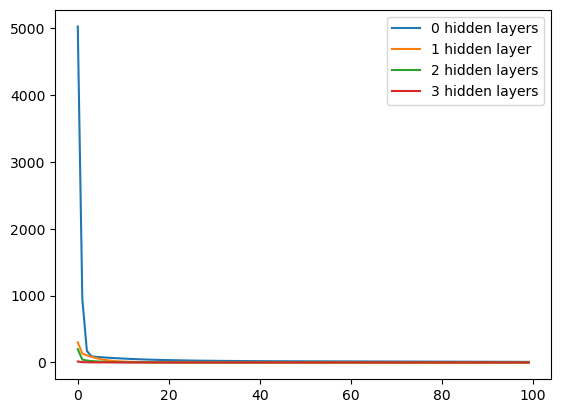

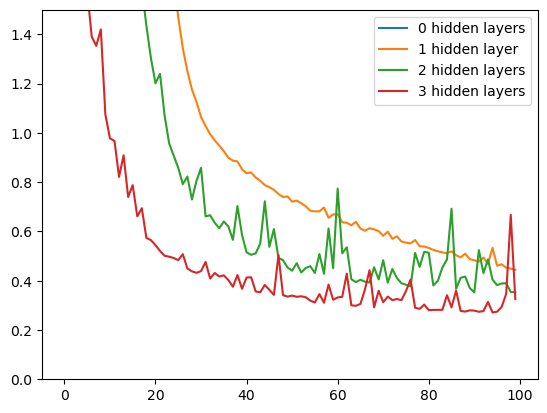

In [22]:
plt.plot(history_1.history['val_loss'], label='0 hidden layers')
plt.plot(history_2.history['val_loss'], label='1 hidden layer')
plt.plot(history_3.history['val_loss'], label='2 hidden layers')
plt.plot(history_4.history['val_loss'], label='3 hidden layers')
plt.legend()
plt.show()

plt.plot(history_1.history['val_loss'], label='0 hidden layers')
plt.plot(history_2.history['val_loss'], label='1 hidden layer')
plt.plot(history_3.history['val_loss'], label='2 hidden layers')
plt.plot(history_4.history['val_loss'], label='3 hidden layers')
plt.ylim(0, 1.5)
plt.legend()
plt.show()

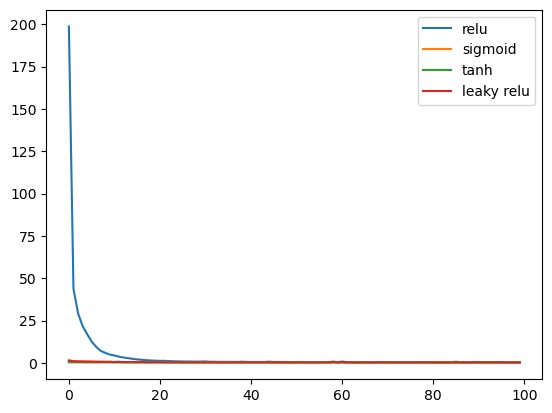

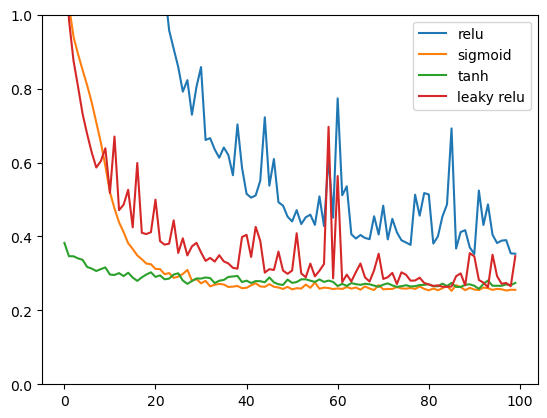

In [23]:
plt.plot(history_3.history['val_loss'], label='relu')
plt.plot(history_3_sigmoid.history['val_loss'], label='sigmoid')
plt.plot(history_3_tanh.history['val_loss'], label='tanh')
plt.plot(history_3_leaky.history['val_loss'], label='leaky relu')
plt.legend()
plt.show()

plt.plot(history_3.history['val_loss'], label='relu')
plt.plot(history_3_sigmoid.history['val_loss'], label='sigmoid')
plt.plot(history_3_tanh.history['val_loss'], label='tanh')
plt.plot(history_3_leaky.history['val_loss'], label='leaky relu')
plt.legend()
plt.ylim(0, 1)
plt.show()

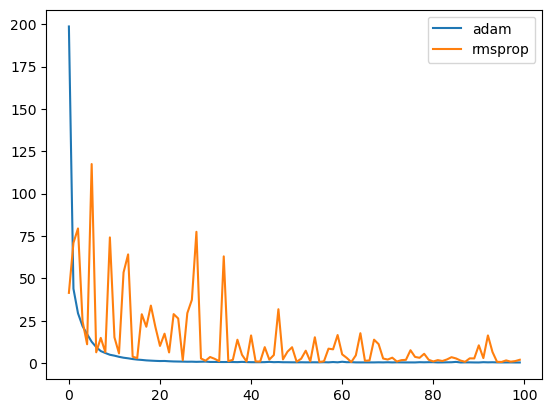

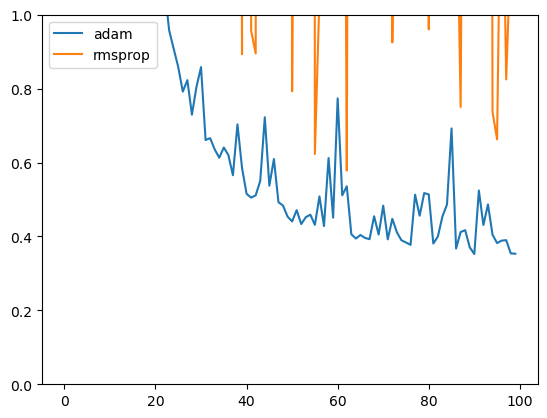

In [24]:
plt.plot(history_3.history['val_loss'], label='adam')
plt.plot(history_3_rms.history['val_loss'], label='rmsprop')
plt.legend()
plt.show()

plt.plot(history_3.history['val_loss'], label='adam')
plt.plot(history_3_rms.history['val_loss'], label='rmsprop')
plt.legend()
plt.ylim(0, 1)
plt.show()

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

print("Decision Tree ...")
tree_model = DecisionTreeRegressor(max_depth=8)
tree_model.fit(X_train_features[features_to_keep], Y_train['content'])

print("KNN ...")
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_features[features_to_keep], Y_train['content'])

print("Linear Regression ...")
linear_model = LinearRegression()
linear_model.fit(X_train_features[features_to_keep], Y_train['content'])

Decision Tree ...
KNN ...
Linear Regression ...


LinearRegression()

## Análisis de Resultados

In [26]:
def plot_predictions(df, target_col, pred_col):
    sns.jointplot(
        x=target_col, 
        y=pred_col,
        data=df_val,
        kind='reg',
        joint_kws=dict(line_kws=dict(color='r', linewidth=3), scatter_kws=dict(alpha=0.5, s=10)),
    )
    plt.show()

def plot_predictions_features(df, features, target_col, pred_col, bins=5):
    df_plot = df.copy()
    
    r2_general = mean_squared_error(df_plot[target_col], df_plot[pred_col])
    
    for col in features:
        df_plot[col] = pd.qcut(df[col], q=bins, labels=False)
        
        sns.jointplot(
            x=target_col, 
            y=pred_col,
            data=df_plot,
            kind='scatter',
            hue=col
            #joint_kws=dict(line_kws=dict(color='r', linewidth=3), scatter_kws=dict(alpha=0.5, s=10)),
        )
        
        plt.show()
        
        r2_bins = [mean_squared_error(
            df_plot[df_plot[col] == i][target_col], 
            df_plot[df_plot[col] == i][pred_col]
        ) for i in range(bins)]
        
        plt.axhline(y=r2_general, color='r', linestyle='--')
        plt.plot(r2_bins)
        plt.title(col + ' R2 scores')
        plt.show()
        
def plot_predictions_comparisson(df, features, target_col, pred_col_1, pred_col_2, bins=5):
    df_plot = df.copy()
    
    r2_general_1 = mean_squared_error(df_plot[target_col], df_plot[pred_col_1])
    r2_general_2 = mean_squared_error(df_plot[target_col], df_plot[pred_col_2])
    
    for col in features:
        df_plot[col] = pd.qcut(df[col], q=bins, labels=False)
        
        r2_bins_1 = [mean_squared_error(
            df_plot[df_plot[col] == i][target_col], 
            df_plot[df_plot[col] == i][pred_col_1]
        ) for i in range(bins)]
        
        r2_bins_2 = [mean_squared_error(
            df_plot[df_plot[col] == i][target_col], 
            df_plot[df_plot[col] == i][pred_col_2]
        ) for i in range(bins)]
        
        plt.axhline(y=r2_general_1, color='#1f77b4', linestyle='--')
        plt.axhline(y=r2_general_2, color='#ff7f0e', linestyle='--')
        plt.plot(r2_bins_1, label=pred_col_1, color='#1f77b4')
        plt.plot(r2_bins_2, label=pred_col_2, color='#ff7f0e')
        plt.legend()
        plt.title(col + ' MSE scores')
        plt.show()

In [28]:
df_val = X_val.join(Y_val)
df_val['0 hidden layers'] = model_1.predict(X_val_features[features_to_keep])
df_val['1 hidden layer'] = model_2.predict(X_val_features[features_to_keep])
df_val['2 hidden layers'] = model_3.predict(X_val_features[features_to_keep])
df_val['3 hidden layers'] = model_4.predict(X_val_features[features_to_keep])

df_val['relu'] = df_val['2 hidden layers']
df_val['sigmoid'] = model_3_sigmoid.predict(X_val_features[features_to_keep])
df_val['tanh'] = model_3_tanh.predict(X_val_features[features_to_keep])
df_val['leaky_relu'] = model_3_leaky.predict(X_val_features[features_to_keep])

df_val['adam'] = df_val['2 hidden layers']
df_val['rmsprop'] = model_3_rms.predict(X_val_features[features_to_keep])

df_val['linear regression'] = linear_model.predict(X_val[features_to_keep])
df_val['decision tree'] = tree_model.predict(X_val[features_to_keep])
df_val['k nearest neighbors'] = knn_model.predict(X_val[features_to_keep])

df_val.head()

45/45 [==============================] - 0s 1ms/step


,text,prompt_question,prompt_text,spelling_errors_essay,grammar_errors_essay,punctuation_marks_essay,essay_lemmatized,text_length_essay,sent_count_essay,word_count_essay,...,3 hidden layers,relu,sigmoid,tanh,leaky_relu,adam,rmsprop,linear regression,decision tree,k nearest neighbors
1759,The factory mixed spoiled meat with other mea...,Summarize the various ways the factory would u...,"With one member trimming beef in a cannery, an...",5,2,8,the factory mixed spoiled meat with other meat...,347,3.0,70.0,...,0.130402,0.134745,-0.123487,-0.075036,-0.299743,0.134745,-0.291999,-0.355105,0.023230,-0.080401
2313,they ould chop it up cover the smell put gelit...,Summarize the various ways the factory would u...,"With one member trimming beef in a cannery, an...",3,7,1,they ould chop it up cover the smell put genit...,226,1.0,49.0,...,-0.907540,-1.516628,-1.144808,-0.999588,-1.168862,-1.516628,-1.338994,-0.928913,-0.855483,-0.874377
2282,1 element of and ideal tragedy is the down fal...,Summarize at least 3 elements of an ideal trag...,Chapter 13 \r\nAs the sequel to what has alrea...,3,7,1,element of and ideal tragedy is the down fall ...,331,1.0,63.0,...,-0.132259,-0.360048,-0.348504,-0.537877,-0.507599,-0.360048,-0.678954,-0.122956,-0.381562,-0.332981
2740,The factorys would do anything in their power ...,Summarize the various ways the factory would u...,"With one member trimming beef in a cannery, an...",8,2,7,the factory would do anything in their power t...,286,2.0,58.0,...,-0.246212,0.002996,-0.392475,-0.530189,-0.608757,0.002996,-1.329100,-0.554723,-0.112342,-0.176514
3978,Public pressure during the aftermath of the bo...,Summarize the various ways the factory would u...,"With one member trimming beef in a cannery, an...",3,0,3,public pressure during the aftermath of the bo...,180,1.0,29.0,...,-1.024628,-0.786224,-1.084427,-1.005044,-0.991170,-0.786224,-1.814765,-1.349722,-1.180615,-1.135166


### Resultados Deep Learning

CONTENT TEST
std = 1.0220265405010216
rmse = 3.0587281402540873
r2 = -7.956893479548329 



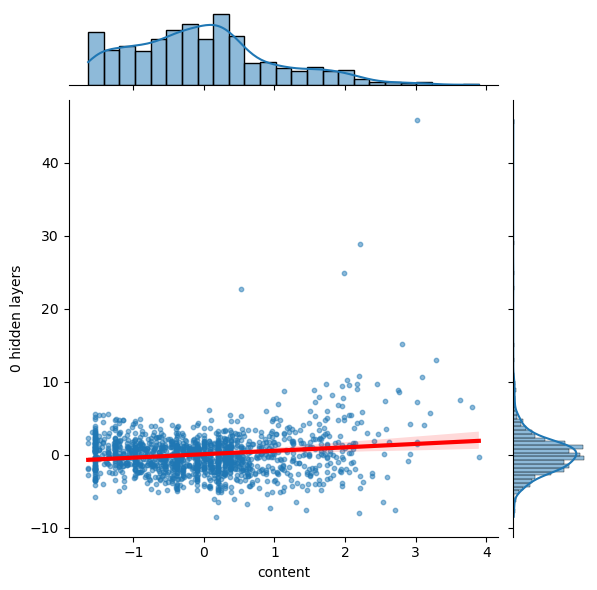

CONTENT TEST
std = 1.0220265405010216
rmse = 0.666513799421214
r2 = 0.5747014098943246 



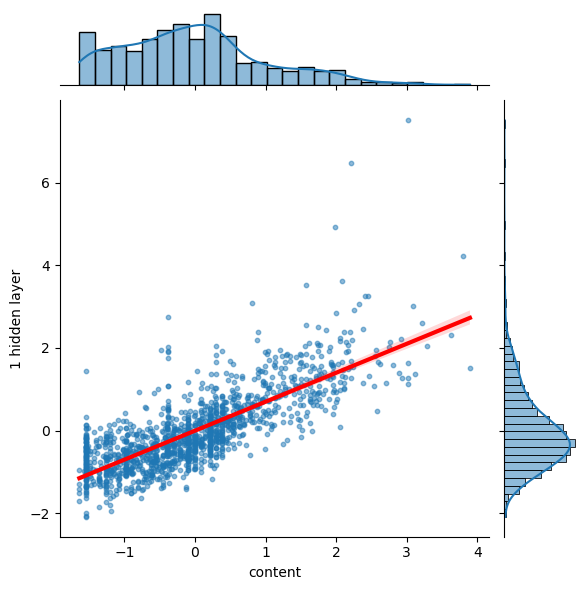

CONTENT TEST
std = 1.0220265405010216
rmse = 0.594275307630364
r2 = 0.6618954438172947 



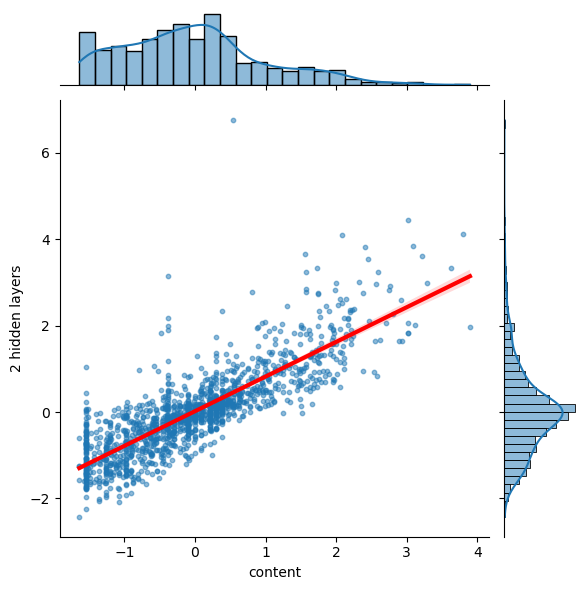

CONTENT TEST
std = 1.0220265405010216
rmse = 0.5706097077874311
r2 = 0.6882876823508345 



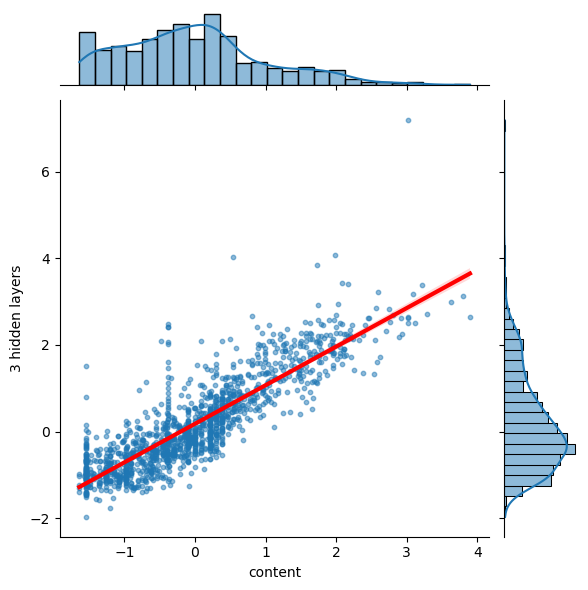

In [29]:
regression_report(df_val['content'], df_val['0 hidden layers'], 'CONTENT TEST')
plot_predictions(df_val, 'content', '0 hidden layers')

regression_report(df_val['content'], df_val['1 hidden layer'], 'CONTENT TEST')
plot_predictions(df_val, 'content', '1 hidden layer')

regression_report(df_val['content'], df_val['2 hidden layers'], 'CONTENT TEST')
plot_predictions(df_val, 'content', '2 hidden layers')

regression_report(df_val['content'], df_val['3 hidden layers'], 'CONTENT TEST')
plot_predictions(df_val, 'content', '3 hidden layers')

CONTENT TEST
std = 1.0220265405010216
rmse = 0.594275307630364
r2 = 0.6618954438172947 



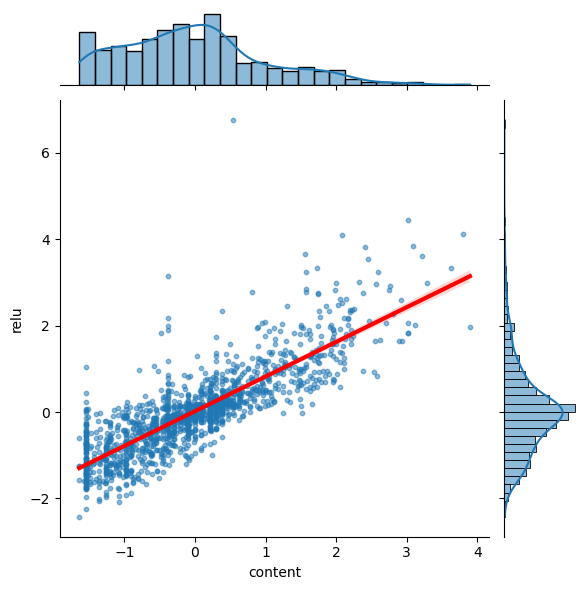

CONTENT TEST
std = 1.0220265405010216
rmse = 0.5054805750791324
r2 = 0.7553841499749241 



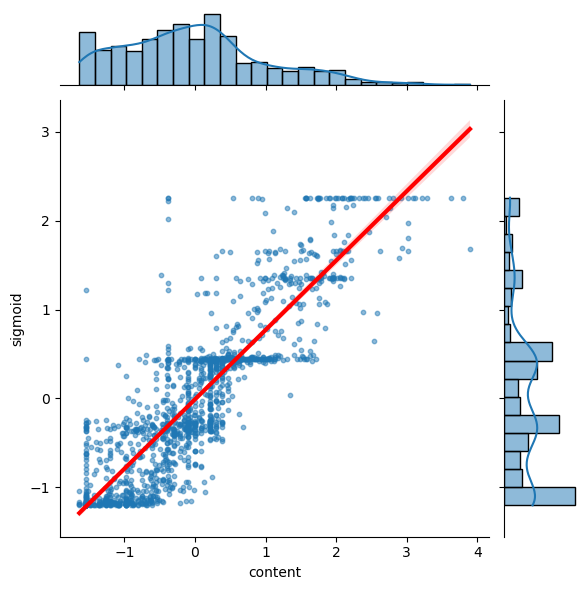

CONTENT TEST
std = 1.0220265405010216
rmse = 0.5236068120301064
r2 = 0.7375260372335902 



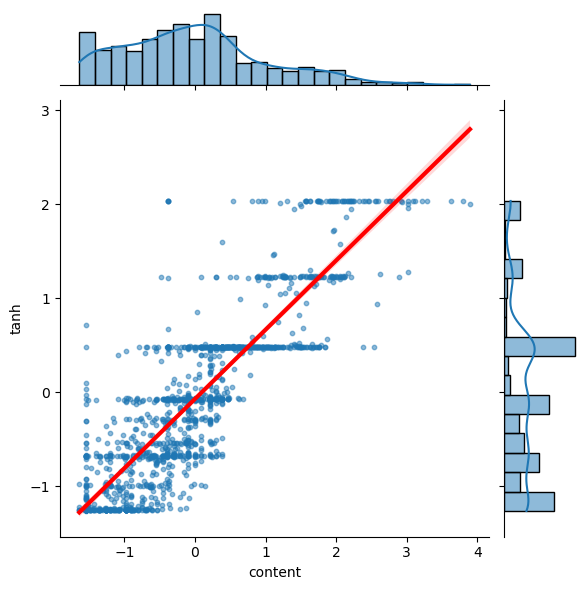

CONTENT TEST
std = 1.0220265405010216
rmse = 0.5887706580342241
r2 = 0.6681300201961871 



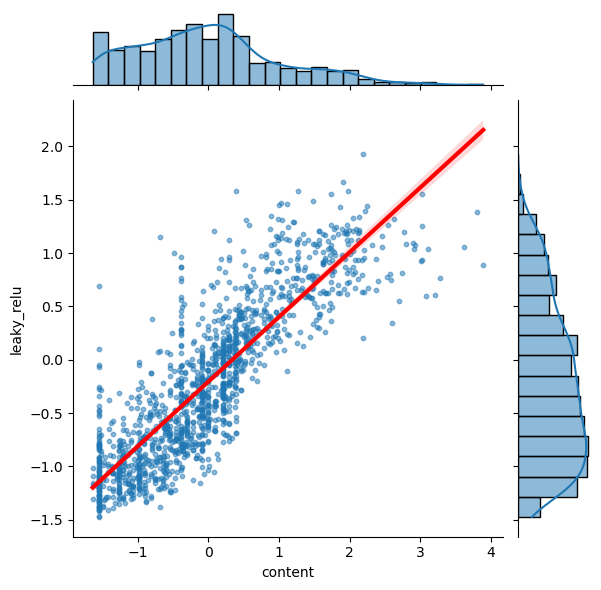

In [30]:
regression_report(df_val['content'], df_val['relu'], 'CONTENT TEST')
plot_predictions(df_val, 'content', 'relu')

regression_report(df_val['content'], df_val['sigmoid'], 'CONTENT TEST')
plot_predictions(df_val, 'content', 'sigmoid')

regression_report(df_val['content'], df_val['tanh'], 'CONTENT TEST')
plot_predictions(df_val, 'content', 'tanh')

regression_report(df_val['content'], df_val['leaky_relu'], 'CONTENT TEST')
plot_predictions(df_val, 'content', 'leaky_relu')

CONTENT TEST
std = 1.0220265405010216
rmse = 0.594275307630364
r2 = 0.6618954438172947 



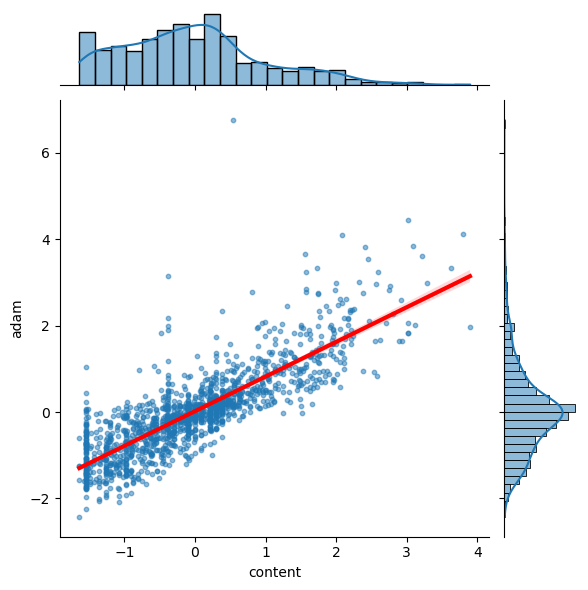

CONTENT TEST
std = 1.0220265405010216
rmse = 1.3955629769523394
r2 = -0.8645521344898806 



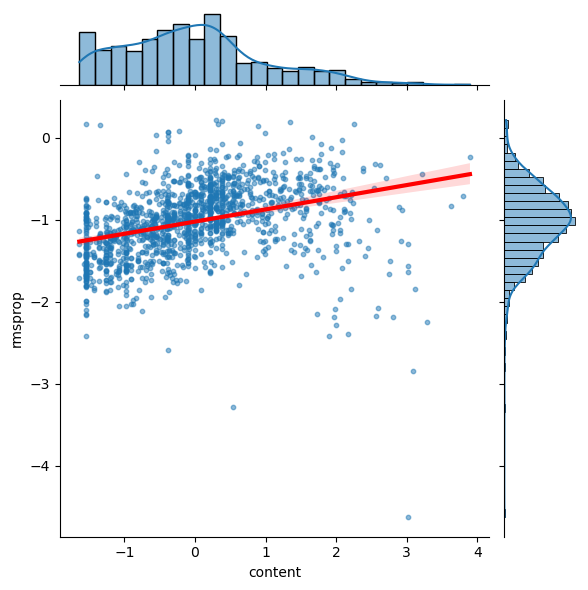

In [31]:
regression_report(df_val['content'], df_val['adam'], 'CONTENT TEST')
plot_predictions(df_val, 'content', 'adam')

regression_report(df_val['content'], df_val['rmsprop'], 'CONTENT TEST')
plot_predictions(df_val, 'content', 'rmsprop')

CONTENT TEST
std = 1.0220265405010216
rmse = 0.5393045436954133
r2 = 0.7215521873009931 



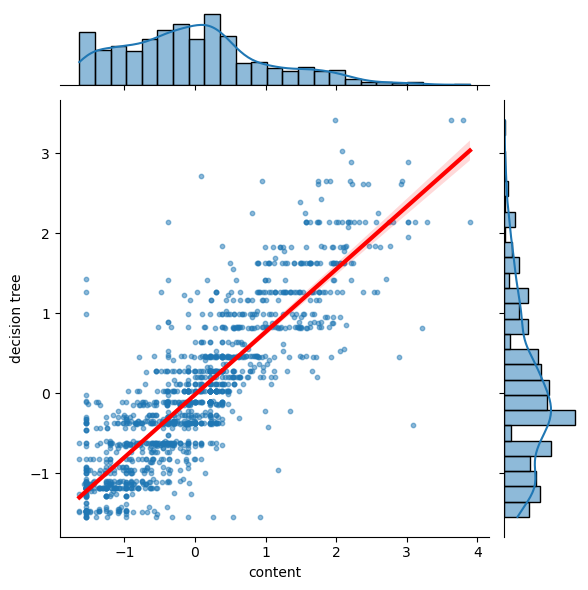

CONTENT TEST
std = 1.0220265405010216
rmse = 0.5241941715490693
r2 = 0.7369368430303284 



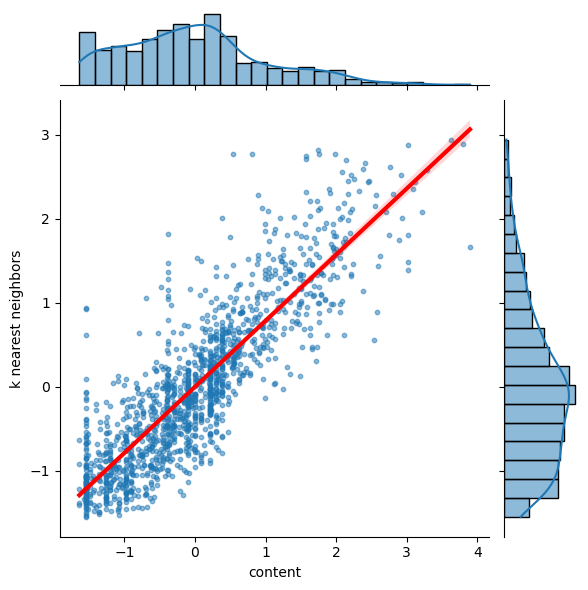

CONTENT TEST
std = 1.0220265405010216
rmse = 0.5787110132281034
r2 = 0.6793736974251507 



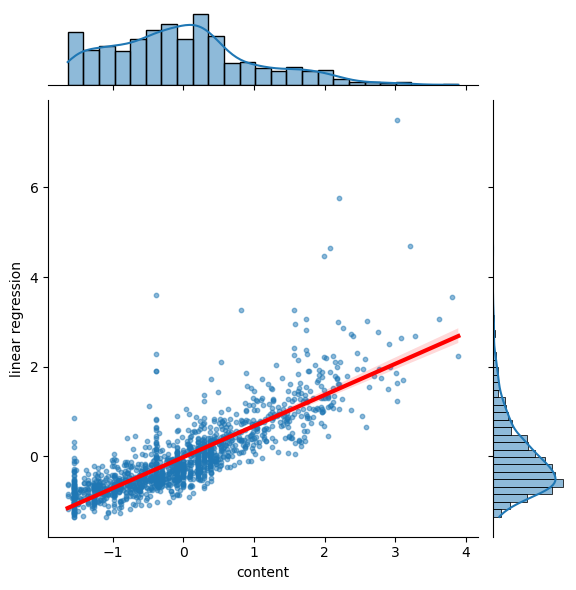

In [33]:
regression_report(df_val['content'], df_val['decision tree'], 'CONTENT TEST')
plot_predictions(df_val, 'content', 'decision tree')

regression_report(df_val['content'], df_val['k nearest neighbors'], 'CONTENT TEST')
plot_predictions(df_val, 'content', 'k nearest neighbors')

regression_report(df_val['content'], df_val['linear regression'], 'CONTENT TEST')
plot_predictions(df_val, 'content', 'linear regression')